# Master Thesis Notebook

## Setup

In [1]:
# Importation of the classes and methods associated
from classes import *

## GPR VWC Analysis

### Raw data

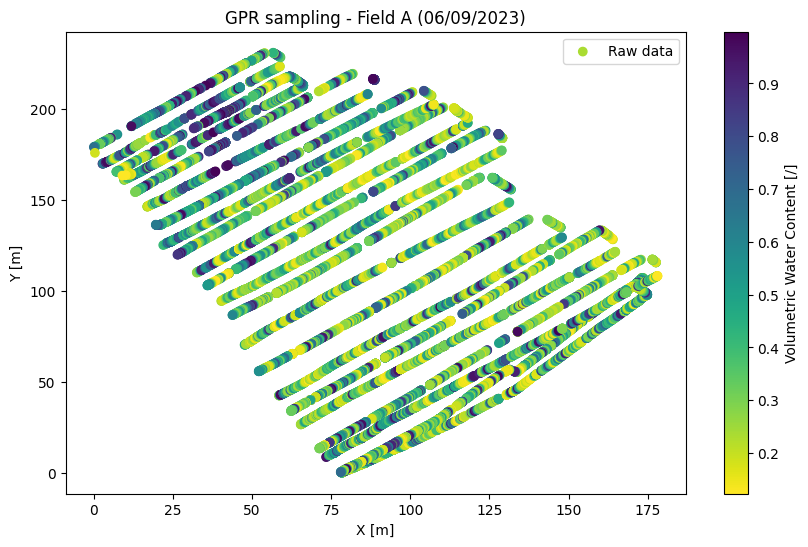

In [2]:
# Instance creation
gpr_a = GprAnalysis(field_paths=GprAnalysis.FIELD_A_PATHS, sample_number=4)  # Sample number [0-11] # FIELD_A/B_PATHS
# Raw Sample
gpr_a.plot_raw_data(plot=True)

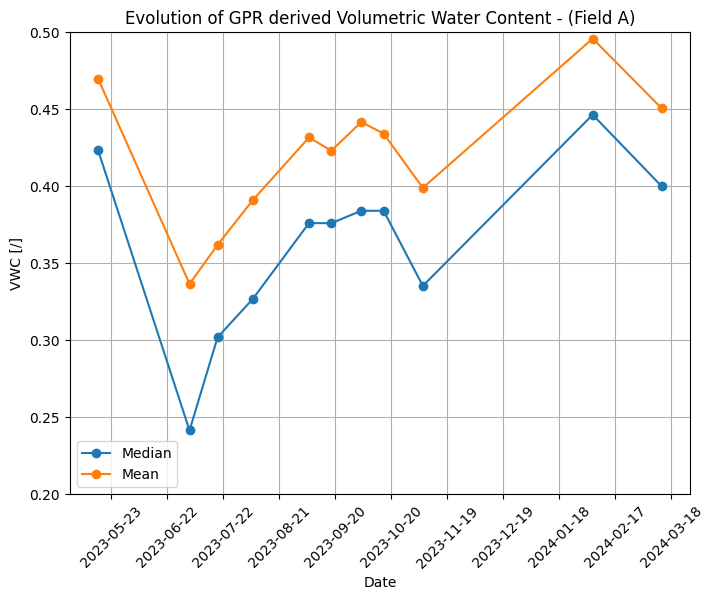

In [3]:
# Mean and median evolution (raw data)
gpr_a.plot_mean_median(plot=True)

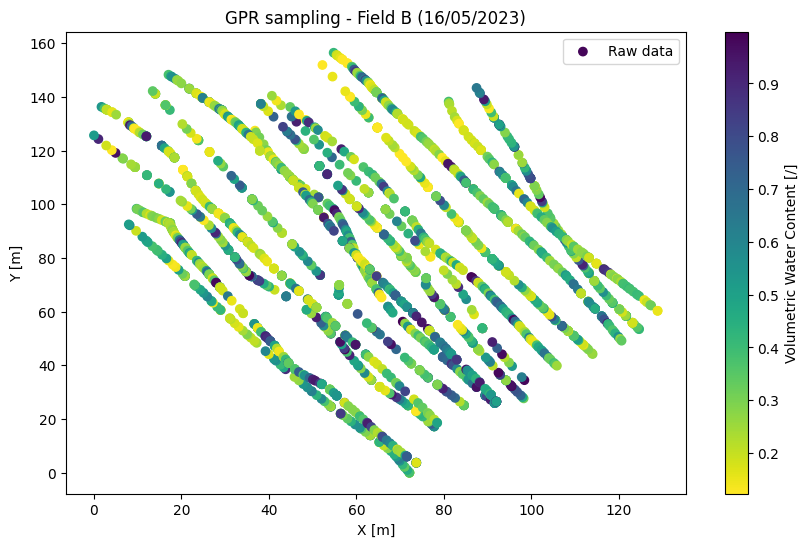

In [4]:
# Instance creation
gpr_b = GprAnalysis(field_paths=GprAnalysis.FIELD_B_PATHS, sample_number=0)  # Sample number [0-11] # FIELD_A/B_PATHS
# Raw Sample
gpr_b.plot_raw_data(plot=True)

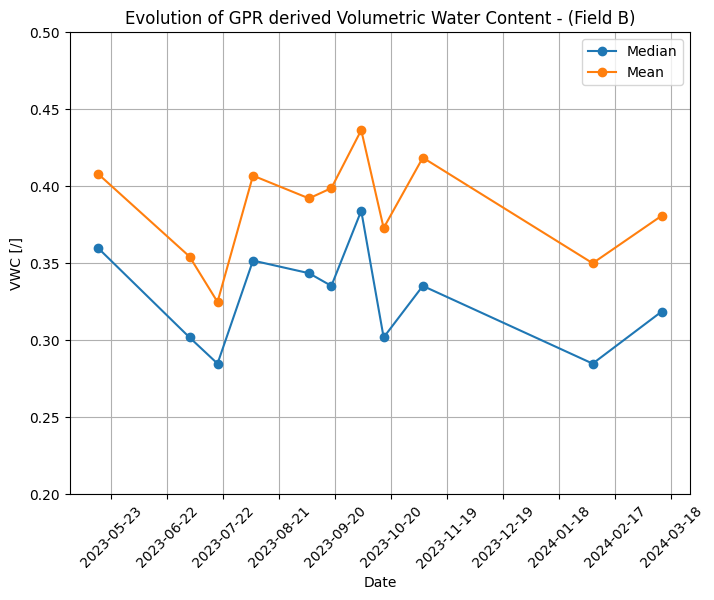

In [5]:
# Median evolution (raw data)
gpr_b.plot_mean_median(plot=True)

### Choosing the variogram model

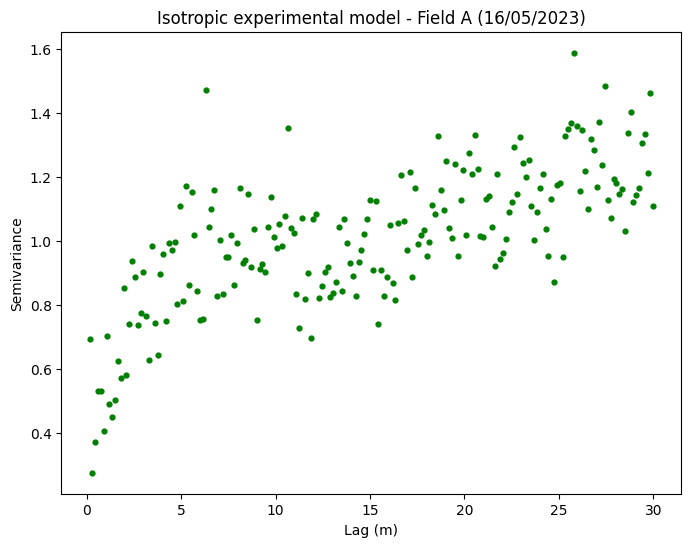

(< spherical Semivariogram fitted to 200 bins >,
 array([ 0.14999724,  0.29999449,  0.44999173,  0.59998897,  0.74998622,
         0.89998346,  1.0499807 ,  1.19997795,  1.34997519,  1.49997243,
         1.64996968,  1.79996692,  1.94996417,  2.09996141,  2.24995865,
         2.3999559 ,  2.54995314,  2.69995038,  2.84994763,  2.99994487,
         3.14994211,  3.29993936,  3.4499366 ,  3.59993384,  3.74993109,
         3.89992833,  4.04992557,  4.19992282,  4.34992006,  4.4999173 ,
         4.64991455,  4.79991179,  4.94990904,  5.09990628,  5.24990352,
         5.39990077,  5.54989801,  5.69989525,  5.8498925 ,  5.99988974,
         6.14988698,  6.29988423,  6.44988147,  6.59987871,  6.74987596,
         6.8998732 ,  7.04987044,  7.19986769,  7.34986493,  7.49986217,
         7.64985942,  7.79985666,  7.94985391,  8.09985115,  8.24984839,
         8.39984564,  8.54984288,  8.69984012,  8.84983737,  8.99983461,
         9.14983185,  9.2998291 ,  9.44982634,  9.59982358,  9.74982083,
  

In [6]:
experimental_vario_a = Variogram(resolution=0.00002, field_paths=GprAnalysis.FIELD_A_PATHS, sample_number=0)

experimental_vario_a.determ_experimental_vario()
# ; hide output of the cell

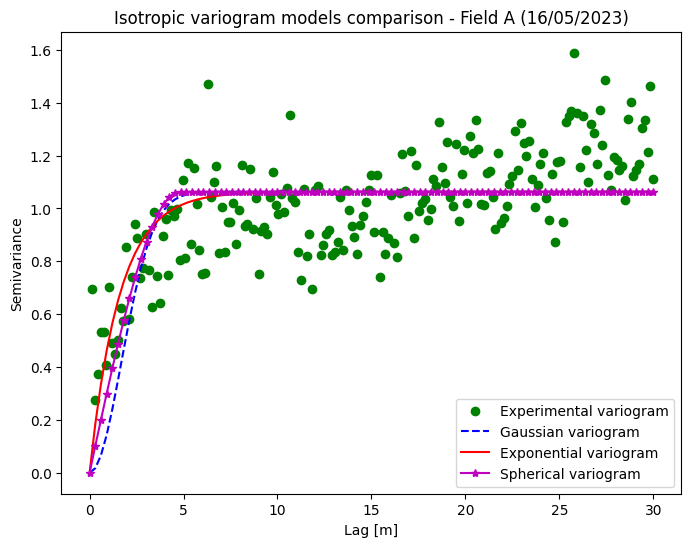

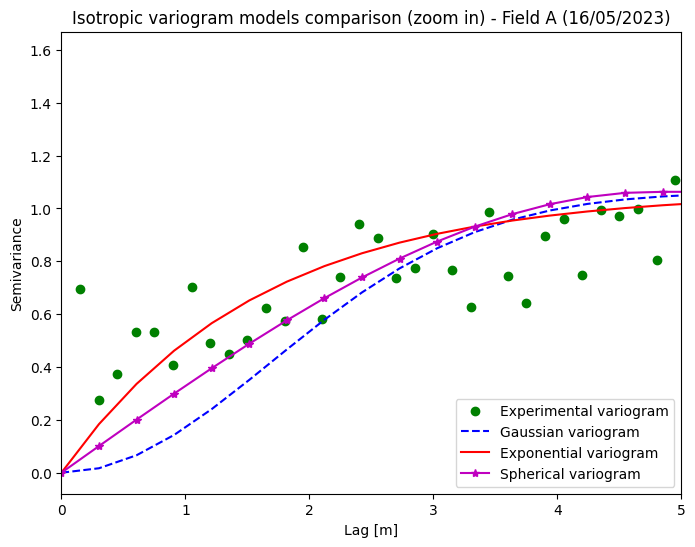

In [7]:
experimental_vario_a.fit_models()

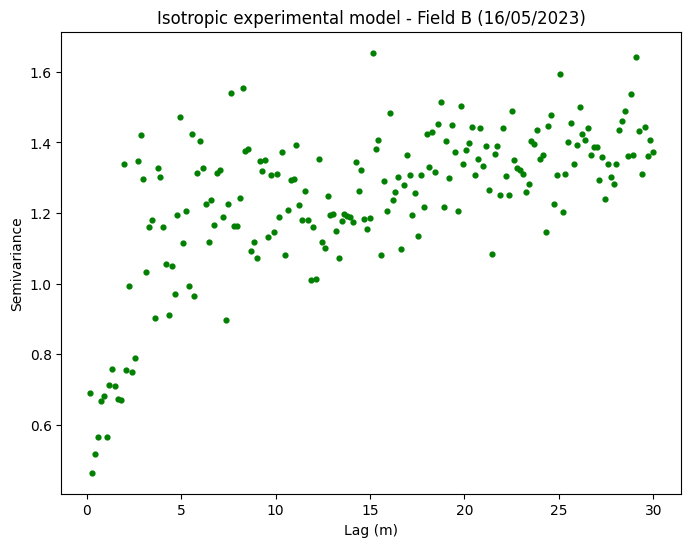

(< spherical Semivariogram fitted to 200 bins >,
 array([ 0.14999968,  0.29999935,  0.44999903,  0.59999871,  0.74999839,
         0.89999806,  1.04999774,  1.19999742,  1.34999709,  1.49999677,
         1.64999645,  1.79999612,  1.9499958 ,  2.09999548,  2.24999516,
         2.39999483,  2.54999451,  2.69999419,  2.84999386,  2.99999354,
         3.14999322,  3.2999929 ,  3.44999257,  3.59999225,  3.74999193,
         3.8999916 ,  4.04999128,  4.19999096,  4.34999064,  4.49999031,
         4.64998999,  4.79998967,  4.94998934,  5.09998902,  5.2499887 ,
         5.39998837,  5.54998805,  5.69998773,  5.84998741,  5.99998708,
         6.14998676,  6.29998644,  6.44998611,  6.59998579,  6.74998547,
         6.89998515,  7.04998482,  7.1999845 ,  7.34998418,  7.49998385,
         7.64998353,  7.79998321,  7.94998289,  8.09998256,  8.24998224,
         8.39998192,  8.54998159,  8.69998127,  8.84998095,  8.99998062,
         9.1499803 ,  9.29997998,  9.44997966,  9.59997933,  9.74997901,
  

In [8]:
experimental_vario_b = Variogram(resolution=0.00002, field_paths=GprAnalysis.FIELD_B_PATHS, sample_number=0)

experimental_vario_b.determ_experimental_vario()
# ; hide output of the cell

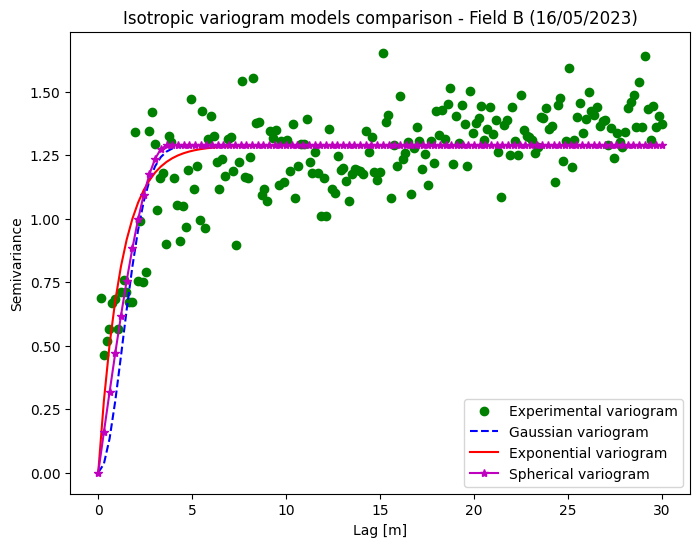

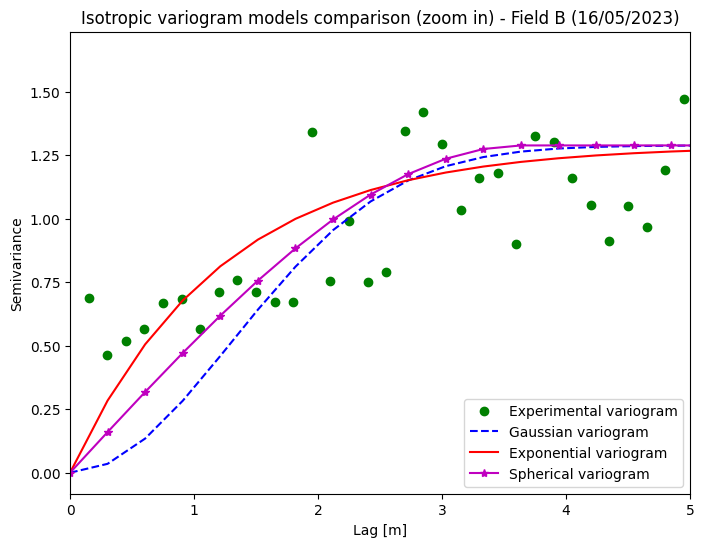

In [9]:
experimental_vario_b.fit_models()

### Kriged data

In [10]:
gpr_a.kriging(x_grid_step=1, y_grid_step=1, plot=True)

KeyboardInterrupt: 

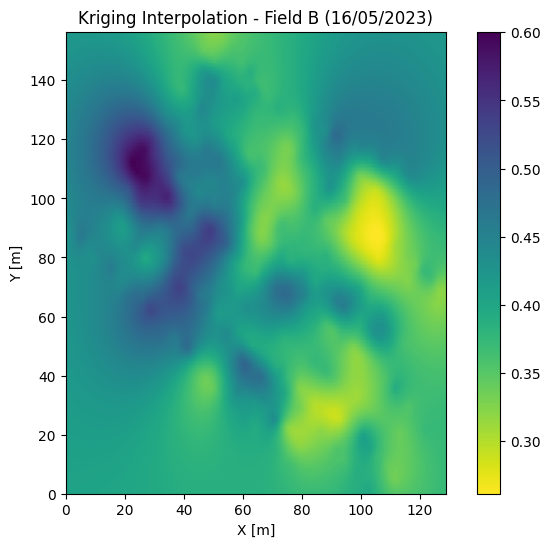

(1, 1)

In [ ]:
gpr_b.kriging(x_grid_step=1, y_grid_step=1, plot=True)

## TDR Verification

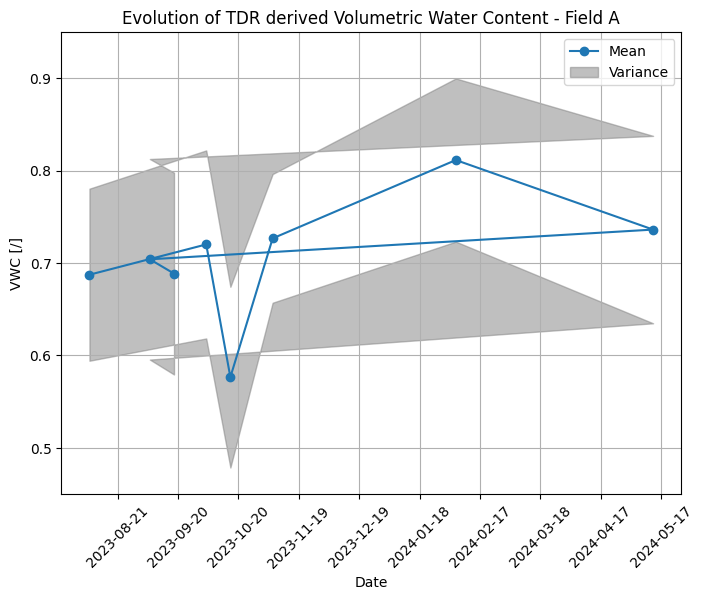

ValueError: x and y must have same first dimension, but have shapes (8,) and (0,)

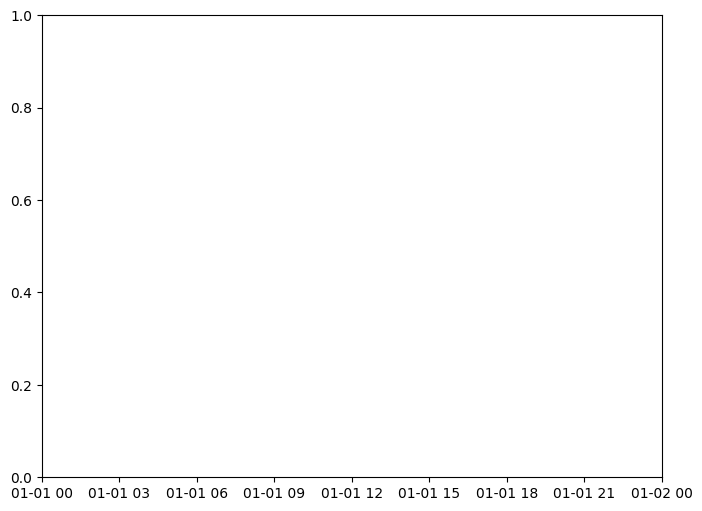

In [ ]:
test = TdrAnalysis()
test.plot_tdr_evolution()

## Multispectral analysis

### TVDI

The formula used for the Temperature Vegetation Dryness Index (TVDI) calculation is:

$$ \text{TVDI} = \frac{\text{LST} - T_{\text{min}}(\text{NDVI})}{T_{\text{max}}(\text{NDVI}) - T_{\text{min}}(\text{NDVI})} $$

Where:
- LST is the Land Surface Temperature for a given pixel.
- T max NDVI is the maximum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{max}}(\text{NDVI}) = a \cdot \text{NDVI} + b $$
- T min NDVI is the minimum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{min}}(\text{NDVI}) = c \cdot \text{NDVI} + d $$

Here the specific linear functions used were:

$$ T_{\text{max}}(\text{NDVI}) = 40 \cdot \text{NDVI} + 300 $$

$$ T_{\text{min}}(\text{NDVI}) = 20 \cdot \text{NDVI} + 250 $$


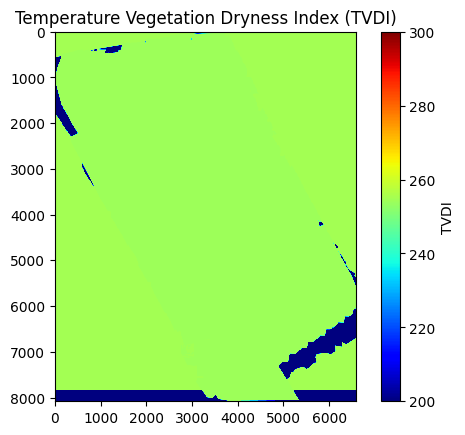

In [ ]:
multi_a = MultispecAnalysis(
    temperature_raster=MultispecAnalysis.TEMPERATURE_RASTER, ndvi_raster=MultispecAnalysis.NDVI_RASTER
)

multi_a.calculate_tvdi()